In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import random

from avcs.classification import eenn_avcs_classification, marignal_coverage_classification, sizes_classification, \
                                    find_relu_thresholds, running_intersection_classification, consistency_classifciation
from utils.raps import raps_eenn

import utils.plotting_style
from matplotlib.lines import Line2D

In [35]:
ALPHA = 0.05
CALIB_SIZE = 0.2  # % of test dataset set aside for calibration

SEED = 0

## 1) Compute EENN-AVCS

In [36]:
# EENN-AVCS
C_AVCS = {}
for dataset in ['CIFAR_10', 'CIFAR_100', 'ImageNet']:

    logits, targets = torch.load(f'data/msdnet/logits_MSDNet_{dataset}.pth') 
    logits = logits.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    L, N, C = logits.shape

    random.seed(SEED)
    calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
    valid_ids = list(set(range(N)) - set(calib_ids))
    logits_calib = logits[:, calib_ids, :]
    targets_calib = targets[calib_ids]

    relu_thres = find_relu_thresholds(logits, targets, init_thresholds=np.ones(L), alpha=0.05, seed=SEED)

    c_avcs = eenn_avcs_classification(logits[:, valid_ids, :], thresholds=relu_thres, alpha=ALPHA, seed=SEED)
    
    C_AVCS[dataset] = (c_avcs, targets[valid_ids])

0 [5.5 1.  1.  1.  1.  1.  1. ]
1 [5.5 4.5 1.  1.  1.  1.  1. ]
2 [5.5 4.5 2.  1.  1.  1.  1. ]
3 [5.5 4.5 2.  1.5 1.  1.  1. ]
4 [5.5 4.5 2.  1.5 2.  1.  1. ]
5 [5.5 4.5 2.  1.5 2.  1.  1. ]
6 [5.5 4.5 2.  1.5 2.  1.  1. ]
0 [5.5 1.  1.  1.  1.  1.  1. ]
1 [5.5 3.  1.  1.  1.  1.  1. ]
2 [5.5 3.  2.5 1.  1.  1.  1. ]
3 [5.5 3.  2.5 1.5 1.  1.  1. ]
4 [5.5 3.  2.5 1.5 1.5 1.  1. ]
5 [5.5 3.  2.5 1.5 1.5 1.  1. ]
6 [5.5 3.  2.5 1.5 1.5 1.  1. ]
0 [4.5 1.  1.  1.  1. ]
1 [4.5 5.  1.  1.  1. ]
2 [4.5 5.  4.  1.  1. ]
3 [4.5 5.  4.  3.5 1. ]
4 [4.5 5.  4.  3.5 2.5]


## 2) Compute RAPS

In [38]:
# RAPS
C_RAPS = {}
C_RAPS_INTERSECT = {}
for dataset in ['CIFAR_10', 'CIFAR_100', 'ImageNet']:
    
    PATH = f'data/msdnet/logits_MSDNet_{dataset}.pth'
    logits, targets = torch.load(PATH) 
    probs = torch.softmax(logits, dim=2).detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    _, _, c_raps, targets = raps_eenn(probs, targets, alpha=ALPHA, calib_size=CALIB_SIZE, seed=SEED)
    c_raps_intersect = [running_intersection_classification(c_raps[i]) for i in range(len(c_raps))]

    C_RAPS[dataset] = (c_raps, targets)
    C_RAPS_INTERSECT[dataset] = (c_raps_intersect, targets)

/var/folders/v9/430kxdy15zs97jddd4nb0gjc0000gn/T/ipykernel_2978/462882590.py:53: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(


## 3) Plot results

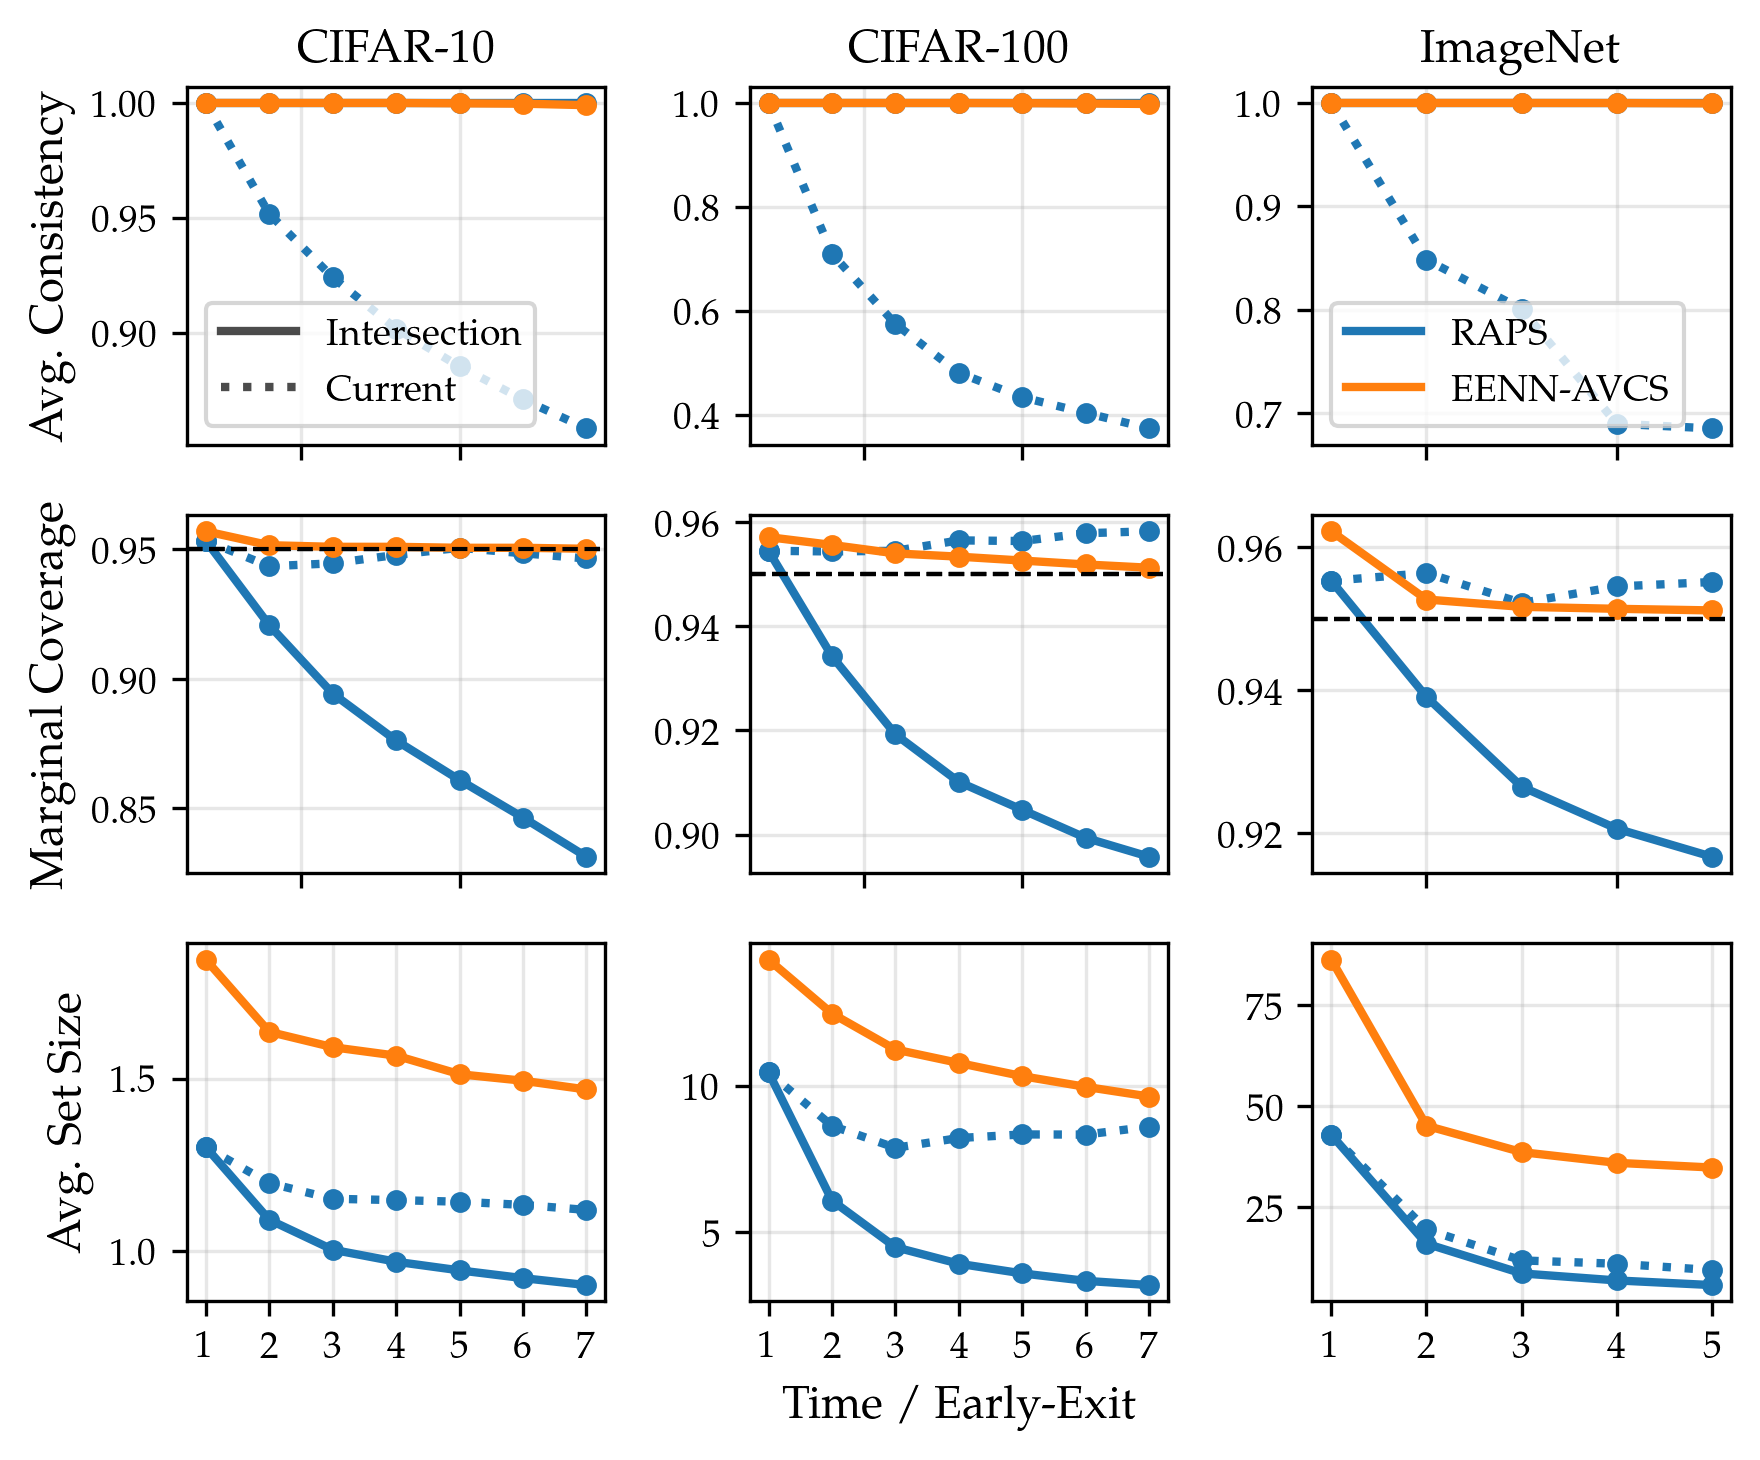

In [42]:
f_ls = lambda x: '-' if ('intersect' in x or 'AVCS' in x) else 'dotted'
f_color = lambda x: 'tab:blue' if 'RAPS' in x else 'tab:orange'

fig, ax = plt.subplots(3, 3, figsize=(6, 5))

for i, dataset in enumerate(['CIFAR_10', 'CIFAR_100', 'ImageNet']):
    L = 5 if dataset == 'ImageNet' else 7
    exits = [l + 1 for l in range(L)]

    for label, c_arr in zip(['RAPS', 'RAPS-intersect', 'EENN-AVCS'], [C_RAPS, C_RAPS_INTERSECT, C_AVCS]):

        consistency = np.array([consistency_classifciation(c_arr[dataset][0][i]) for i in range(len(c_arr[dataset][0]))]).mean(axis=0)

        ax[0, i].plot(exits, consistency, label=label, color=f_color(label), ls=f_ls(label), marker='o', ms=4, lw=2)
        ax[0, i].tick_params(labelbottom=False)

        coverage = marignal_coverage_classification(c_arr[dataset][0], c_arr[dataset][1])

        ax[1, i].plot(exits, coverage, label=label, color=f_color(label), ls=f_ls(label), marker='o', ms=4, lw=2)
        ax[1, i].axhline(y=1 - ALPHA, color='black', linestyle='--')
        ax[1, i].tick_params(labelbottom=False)

        sizes = sizes_classification(c_arr[dataset][0])
        sizes = np.array(sizes).mean(axis=0)

        ax[2, i].plot(exits, sizes, label=label, ls=f_ls(label), color=f_color(label), marker='o', ms=4, lw=2)
        ax[2, i].set_xticks(exits)
        ax[2, i].tick_params(labelbottom=True)

    ax[0, i].set_title(f"{dataset.replace('_', '-')}")
    
ax[0, 0].set_ylabel('Avg. Consistency')
ax[1, 0].set_ylabel('Marginal Coverage')
ax[2, 0].set_ylabel('Avg. Set Size')

ax[2, 1].set_xlabel('Time / Early-Exit')

lines1 = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted', alpha=0.7),
]
labels1 = [
    "Intersection",
    "Current"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-'),
]
labels2 = [
    "RAPS",
    "EENN-AVCS",
]

legend1 = ax[0, 0].legend(lines1, labels1, loc='lower left')
legend2 = ax[0, 2].legend(lines2, labels2, loc='lower left')

plt.tight_layout()
plt.show()
